In [2]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import yfinance as yf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm
from sklearn.metrics import mean_squared_error

## EDA

Most of the EDA was done in the previous implementation.

In [3]:
df = yf.download(tickers='NVDA', start='2015-01-01')

[*********************100%***********************]  1 of 1 completed


In [4]:
df['log_return'] = np.log(1 + df['Adj Close'].pct_change())
df = df.dropna()

In [5]:
def adf_test(dataset):

    dftest = adfuller(dataset, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

    return print(dfoutput)

### Evaluation of Variables
For the data to be stationary, the p-value of the ADF test should be <= significance level (0.05 for this example). If the p-value is greater than the significance level then we can say that it is likely that the data is not stationary.

From the results below, we can see that `'Adj Close'` is almost certainly not stationary but `'log_returns'` is.

In [6]:
adf_test(df['Adj Close'])

Test Statistic                    0.745856
p-value                           0.990710
#Lags Used                       27.000000
Number of Observations Used    2188.000000
dtype: float64


In [7]:
adf_test(df['log_return'])

Test Statistic                -1.686952e+01
p-value                        1.083831e-29
#Lags Used                     7.000000e+00
Number of Observations Used    2.208000e+03
dtype: float64


## Data Preparation

In [8]:
# Define function to split data into train, val, test
def split(dataset, days_to_test):
    
    # DAYS_TO_PRED rows will be removed for test data, remaining split .8 .2
    test_val_len = len(dataset) - days_to_test
    l_80 = int(test_val_len * 0.8)
    train_data, val_data, test_data = dataset[: l_80], dataset[l_80 : test_val_len], dataset[test_val_len :]
    
    if test_data.empty:
        return train_data, val_data
    else:
        return train_data, val_data, test_data

In [9]:
# No need for val data
train_data, test_data = split(df, 0)

In [10]:
df.shape, train_data.shape, test_data.shape

((2216, 7), (1772, 7), (444, 7))

## Model Diagnostics

The Standardized residual, Histogram plus KDE estimate, Normal q-q, and the correlogram. We can interpret the model as a good fit based on the following conditions.

- ### Standardized residual
    There are no obvious patterns in the residuals, with values having a mean of zero and having a uniform variance.

- ### Histogram plus KDE estimate
    The KDE curve should be very similar to the normal distribution (labeled as N(0,1) in the plot)

- ### Normal Q-Q
    Most of the data points should lie on the straight line

- ### Correlogram (ACF plot)
    95% of correlations for lag greater than zero should not be significant. The grey area is the confidence band, and if values fall outside of this then they are statistically significant. In our case, there are a few values outside of this area, and therefore we may need to add more predictors to make the model more accurate

In [11]:
ARIMA_model = pm.auto_arima(df['Adj Close'], 
                      #start_p=1, 
                      #start_q=1,
                      #test='adf',
                      #max_p=3, max_q=3,
                      #m=1, 
                      #d=None,# let model determine 'd'
                      #seasonal=False,
                      trace=True, #logs 
                      #error_action='warn', #shows errors ('ignore' silences these)
                      suppress_warnings=True,
                      stepwise=True)

ARIMA_model.summary()

Performing stepwise search to minimize aic


 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=13223.765, Time=1.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=13217.729, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=13219.040, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=13219.012, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=13219.299, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=13220.102, Time=0.30 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 1.705 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 2216
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -6606.864
Date:                Tue, 24 Oct 2023   AIC                          13217.729
Time:                        22:46:38   BIC                          13229.135
Sample:                             0   HQIC                         13221.895
                               - 2216                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1919      0.109      1.756      0.079      -0.022       0.406
sigma2        22.8212      0.175    130.597      0.000      22.479      23.164
===================================================================================
Ljung-Box (L1) (Q):                   0.69   Jarque-Bera (JB):            106634.04
Prob(Q):                              0.41   Prob(JB):                         0.00
Heteroskedasticity (H):             176.93   Skew:                             2.21
Prob(H) (two-sided):                  0.00   Kurtosis:                        36.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

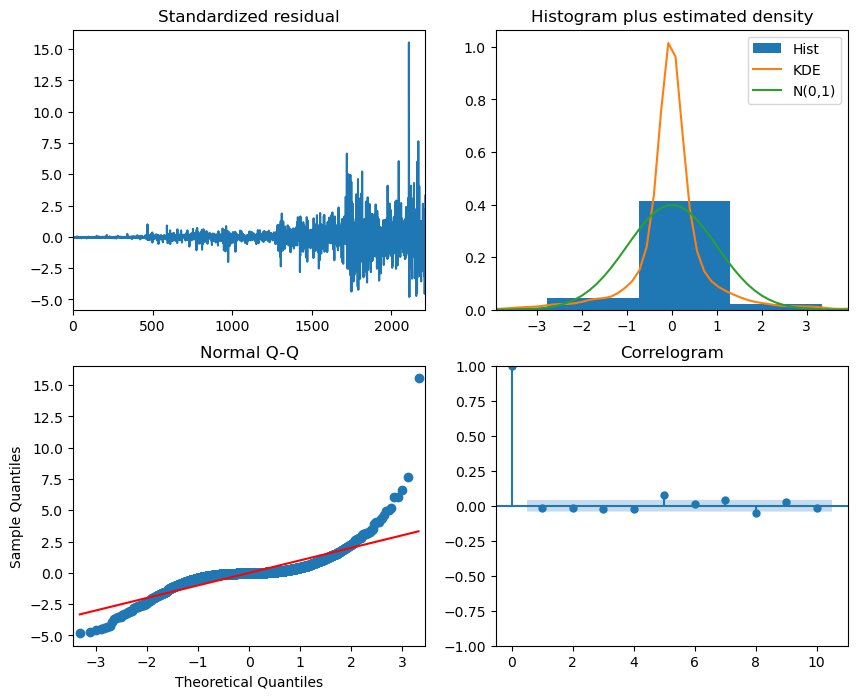

In [12]:
ARIMA_model.plot_diagnostics(figsize=(10, 8))
plt.show()

## ARIMA Implementation

In [13]:
model = ARIMA(train_data['Adj Close'], order=(0, 1, 0))
model = model.fit()
model.summary()

/Users/gareth/anaconda3/envs/lstm/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/gareth/anaconda3/envs/lstm/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/gareth/anaconda3/envs/lstm/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              Adj Close   No. Observations:                 1772
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -4357.505
Date:                Tue, 24 Oct 2023   AIC                           8717.011
Time:                        22:46:39   BIC                           8722.490
Sample:                             0   HQIC                          8719.035
                               - 1772                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         8.0291      0.074    109.165      0.000       7.885       8.173
===================================================================================
Ljung-Box (L1) (Q):                  19.70   Jarque-Bera (JB):             45820.29
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):             144.46   Skew:                             1.14
Prob(H) (two-sided):                  0.00   Kurtosis:                        27.81
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [14]:
test_start_date = len(train_data) # 1772
test_end_date = test_start_date + len(test_data) - 1 # 1772 + 443 - 1

In [15]:
# Prediction on test data
test_predict = model.predict(start=test_start_date, end=test_end_date) # end is pos nt index
test_predict.index = df.index[test_start_date : test_end_date + 1]
test_predict

/Users/gareth/anaconda3/envs/lstm/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/gareth/anaconda3/envs/lstm/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Date
2022-01-18    269.072571
2022-01-19    269.072571
2022-01-20    269.072571
2022-01-21    269.072571
2022-01-24    269.072571
                 ...    
2023-10-17    269.072571
2023-10-18    269.072571
2023-10-19    269.072571
2023-10-20    269.072571
2023-10-23    269.072571
Name: predicted_mean, Length: 444, dtype: float64

### Model Evaluation

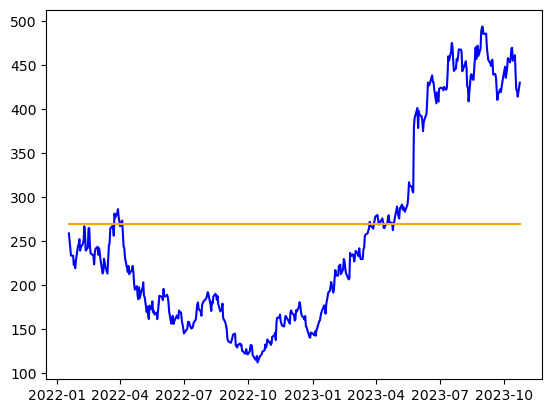

In [16]:
plt.plot(test_data['Adj Close'], color='blue')
plt.plot(test_predict, color='orange')
plt.show()

In [17]:
def calc_rmse(actual, prediction):
    return mean_squared_error(actual, prediction, squared=False)

In [18]:
print(
    #'Train RMSE:', calc_rmse(y_train, train_predict),'\n'
    'Test RMSE:', calc_rmse(test_data['log_return'], test_predict)
    )

Test RMSE: 269.0715187227985


### Make Predictions

In [19]:
def get_prediction(start_index, end_index):

    predictions = model.predict(start=start_index, end=end_index)
    return predictions

In [20]:
def get_prediction_df(dataset, start_date, end_date):

    df = dataset

    # Generate index from date range
    dates = pd.bdate_range(start=start_date, end=end_date)
    dates = pd.Series(data=dates).rename('Date')

    # Reset index of input data
    df.reset_index(inplace=True)

    # Add date column and set as index
    df = pd.concat([df, dates], axis=1)
    df.set_index('Date', inplace=True)

    return df

In [21]:
predictions = get_prediction(len(df), len(df) + 9)

/Users/gareth/anaconda3/envs/lstm/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/gareth/anaconda3/envs/lstm/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [22]:
predictions

2216    269.072571
2217    269.072571
2218    269.072571
2219    269.072571
2220    269.072571
2221    269.072571
2222    269.072571
2223    269.072571
2224    269.072571
2225    269.072571
Name: predicted_mean, dtype: float64

In [23]:
final_df = get_prediction_df('10/25/2023', '11/7/2023', predictions)


TypeError: Cannot convert input [2216    269.072571
2217    269.072571
2218    269.072571
2219    269.072571
2220    269.072571
2221    269.072571
2222    269.072571
2223    269.072571
2224    269.072571
2225    269.072571
Name: predicted_mean, dtype: float64] of type <class 'pandas.core.series.Series'> to Timestamp

In [ ]:
# Define function to take in log returns and return close values
